In [1]:
!pip install evidently

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 13.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 14.1 MB/s eta 0:00:0031m16.7 MB/s eta 0:00:01
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.2 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.20 requires PyYAML==6.0, but you have pyyaml 5.4.1 which is incompatible.


In [2]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.3 MB/s eta 0:00:00 MB/s eta 0:00:01


In [3]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:004.8 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=8a1d9cf209493fd7a1afc3d334d260f4a3fdbbbb1f43bc543c5628a29be4c933
  Stored in directory: /home/enacom/.cache/pip/wheels/6e/ad/de/6e1f2abd50acd8aa9a4c6f2a5201cc8700099ce184922e8724
Successfully built lime


In [18]:
!pip install yellowbrick

  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)


In [64]:
import missingno as msno
import plotly.express as px
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from yellowbrick.target import class_balance
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm

# Import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             roc_auc_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Import mlflow
from mlflow import (
    log_metric, 
    log_param,
    log_figure,
    set_experiment, 
    set_tags,
    start_run,
    end_run,
    set_tracking_uri)

from mlflow.sklearn import log_model

# evidently
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab


# fairlearn
from fairlearn.metrics import MetricFrame

import lime
import lime.lime_tabular


# Propósito do modelo preditivo

>Criação do modelo preditivo, que será **capaz de prever qual paciente tem chance baixa ou alta de ter um ataque cardiaco.**

# Importando a Base de Dados

In [23]:
train = pd.read_csv('./heart.csv')
print(train.shape)
train.head()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Sobre o dataset:

**Age:** Idade dos pacientes

**Sex:** Sexo dos paciente 0 = feminino 1 = masculino

**ChestPainType:** Tipo de dor no peito
   > Valor 1: **Angina típica** consiste em uma dor retroesternal em aperto ou queimação, que dura apenas alguns minutos, piora com esforço ou estresse emocional e é aliviada com repouso ou nitroglicerina.
   
   > Valor 2: **Angina atípica** (p. ex., com meteorismo, flatulência, desconforto abdominal) pode ocorrer em alguns pacientes. Esses pacientes frequentemente descrevem os sintomas para indigestão; eructação pode dar sensação de alívio dos sintomas.
   
   > Valor 3: **Dor não anginosa** uma dor no peito é muito provavelmente não anginosa se sua duração for superior a 30 minutos ou inferior a 5 segundos, aumenta com a inspiração, pode ser provocada com um movimento do tronco ou braço, pode ser provocada por pressão local dos dedos ou inclinação para a frente , ou pode ser aliviado imediatamente ao deitar.
   
   > Valor 0: **Assintomático** ocorre quando o coração não consegue receber sangue e oxigênio suficientes, mas sem que a pessoa sinta sintoma algum como ocorre nos dois tipos anteriores. Esse tipo de angina ocorre quando se pratica exercícios sem se alongar e aquecer os músculos primeiramente e quando se tem diabetes.
   
**BloodPressureRest:** Pressão sanguínea em repouso.(em mmHg(milímetro de Mercúrio) na admissão no hospital)

**Cholesterol:** colestoral em mg/dl obtido via sensor de IMC

**Glycemia:** Glicemia em jejum > 120 mg/dl (1 = verdadeiro; 0 = falso)

**ResultEleccaridoRest:** Resultados eletrocardiográficos em repouso.
   > Valor 0: Normal
   
   > Valor 1: Eletrocaulamento em repouso com anormalidade da onda ST-T (inversões da onda T e/ou elevação ou depressão do segmento ST > 0,05 mV)resultados radiológicos
   
   > Valor 2: Mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes.
   
**MaxHeartRate:** Frequência cardíaca máxima alcançada

**AnginaEx:** Angina induzida por exercício (Angina é o nome dado para a dor no peito causada pela diminuição do fluxo de sangue no coração, o que é chamado de isquemia.)

**STDepression:** Depressão de ST induzida por exercício em relação ao repouso

**STInclinationSeg:** A inclinação do segmento ST do exercício de pico (2 = ascendente; 1 = plana; 0 = descendente)

**NoMainVessels:** Número de vasos principais(0 - 3) (Vasos principais: a aorta, a artéria pulmonar, as veias pulmonares e as veias cavas superior e inferior).

**thall:** 2 = normal 1 = defeito fixo 3 = defeito reversível

**output:** 0 = menos chance de ataque cardíaco 1 = mais chance de ataque cardíaco

In [24]:
train.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [25]:
train.columns = ['Age', 'Sex', 'ChestPainType', 'BloodPressureRest', 'Cholesterol', 'Glycemia', 'ResultEleccaridoRest', 'MaxHeartRate', 'AnginaEx', 'STDepression', 'STInclinationSeg', 'NoMainVessels', 'thall', 'output']
train

,Age,Sex,ChestPainType,BloodPressureRest,Cholesterol,Glycemia,ResultEleccaridoRest,MaxHeartRate,AnginaEx,STDepression,STInclinationSeg,NoMainVessels,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Análise Exploratória de Dados

<AxesSubplot:>

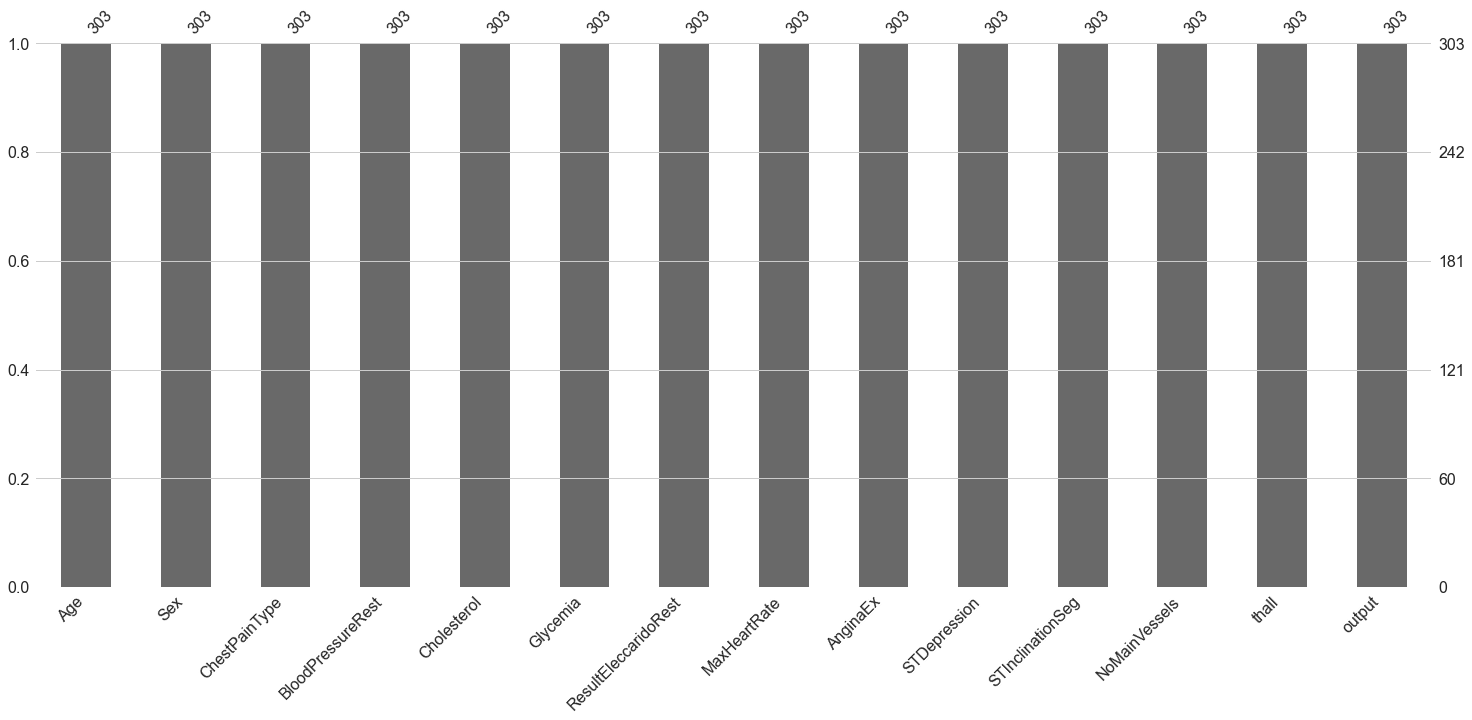

In [26]:
msno.bar(train)

In [27]:
train.describe()

,Age,Sex,ChestPainType,BloodPressureRest,Cholesterol,Glycemia,ResultEleccaridoRest,MaxHeartRate,AnginaEx,STDepression,STInclinationSeg,NoMainVessels,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Class Balance

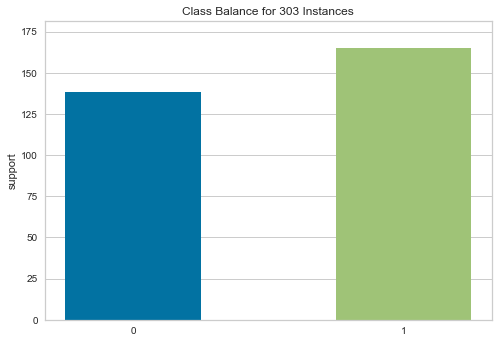

ClassBalance(ax=<AxesSubplot:title={'center':'Class Balance for 303 Instances'}, ylabel='support'>)

In [28]:
class_balance(train['output'])

## Engenharia de Features

## Tipos de dores no peito

>Angina típica consiste em uma dor retroesternal em aperto ou queimação, que dura apenas alguns minutos, piora com esforço ou estresse emocional e é aliviada com repouso ou nitroglicerina.

>Angina atípica (p. ex., com meteorismo, flatulência, desconforto abdominal) pode ocorrer em alguns pacientes. Esses pacientes frequentemente descrevem os sintomas para indigestão; eructação pode dar sensação de alívio dos sintomas.

>Dor não anginosa uma dor no peito é muito provavelmente não anginosa se sua duração for superior a 30 minutos ou inferior a 5 segundos, aumenta com a inspiração, pode ser provocada com um movimento do tronco ou braço, pode ser provocada por pressão local dos dedos ou inclinação para a frente , ou pode ser aliviado imediatamente ao deitar.

>Assintomático ocorre quando o coração não consegue receber sangue e oxigênio suficientes, mas sem que a pessoa sinta sintoma algum como ocorre nos dois tipos anteriores. Esse tipo de angina ocorre quando se pratica exercícios sem se alongar e aquecer os músculos primeiramente e quando se tem diabetes.

In [29]:
train['PainType'] = 'missing'
train.loc[train['ChestPainType'] == 0, 'PainType'] = 'silent_ang'
train.loc[train['ChestPainType'] == 1, 'PainType'] = 'typic_ang'
train.loc[train['ChestPainType'] == 2, 'PainType'] = 'atypic_ang'
train.loc[train['ChestPainType'] == 3, 'PainType'] = 'non_ang_pain'
train

,Age,Sex,ChestPainType,BloodPressureRest,Cholesterol,Glycemia,ResultEleccaridoRest,MaxHeartRate,AnginaEx,STDepression,STInclinationSeg,NoMainVessels,thall,output,PainType
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,non_ang_pain
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,atypic_ang
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,typic_ang
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,typic_ang
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,silent_ang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0,silent_ang
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0,non_ang_pain
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,silent_ang
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0,silent_ang


In [32]:
train['PainType'].value_counts(normalize=True)

silent_ang      0.471947
atypic_ang      0.287129
typic_ang       0.165017
non_ang_pain    0.075908
Name: PainType, dtype: float64

In [34]:
train['Sex'].replace({0: 'female', 1: 'male'}, inplace = True)
train['Sex'].value_counts(normalize=True)

male      0.683168
female    0.316832
Name: Sex, dtype: float64

## Variáveis numericas

In [45]:
num_vars = ['Age', 'BloodPressureRest', 'Glycemia', 'Cholesterol', 'MaxHeartRate', 'AnginaEx', 'STDepression', 'STInclinationSeg']
cat_vars = ['PainType', 'Sex']

In [46]:
for c in num_vars:
    print(f'Valores faltantes: {np.round((train[c].isna().sum() / train.shape[0])*100, 2)}%')
    fig = px.histogram(train, x = c, marginal = "box", color = "output")
    fig.update_layout(title_text = f"Histograma para {c}")
    fig.show()
    

Valores faltantes: 0.0%


Valores faltantes: 0.0%


Valores faltantes: 0.0%


Valores faltantes: 0.0%


Valores faltantes: 0.0%


Valores faltantes: 0.0%


Valores faltantes: 0.0%


Valores faltantes: 0.0%


## Variáveis categoricas

In [53]:
# copy of the dataframe to generate the graphs
df2 = train.copy()
# phanton feature
df2['c'] = 1

for c in cat_vars:
    r= df2.groupby(['output', c]).agg({'count'})['c'].reset_index()
    r['perc'] = r['count'] / df2.shape[0]
    fig = px.histogram(r, x=c, y="perc",
                 color='output', barmode='group')
    fig.update_layout(title_text=f"{c}", yaxis_title="Perc (%)")
    fig.show()  

# Criando um pipeline de treino e teste

In [54]:
X = train.drop(columns=['output'])
y = train['output']

cols = ['Age', 'Sex', 'PainType', 'BloodPressureRest', 'Cholesterol', 'Glycemia', 'MaxHeartRate', 'AnginaEx']
X = X[cols]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("#"*30)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (212, 8)
y_train shape: (212,)
##############################
X_test shape: (91, 8)
y_test shape: (91,)


In [57]:
num_vars = ['Age', 'BloodPressureRest', 'Cholesterol', 'Glycemia', 'MaxHeartRate', 'AnginaEx']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler())]
)

cat_vars = ['Sex', 'PainType']
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='most_frequent')),
           ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first'))])
    
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'BloodPressureRest', 'Cholesterol',
                                  'Glycemia', 'MaxHeartRate', 'AnginaEx']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Sex', 'PainType'])])

In [58]:
clf=RandomForestClassifier(n_estimators=5, 
                           criterion="entropy",
                           random_state=42,
                           n_jobs=-1,
                           max_depth=3,
                           class_weight="balanced")
clf

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, n_estimators=5, n_jobs=-1, random_state=42)

In [59]:
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', clf)])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'BloodPressureRest',
                                                   'Cholesterol', 'Glycemia',
                                                   'MaxHeartRate',
                                                   'AnginaEx']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'PainType'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        n_estimators=5, n_jobs=-1,
                                        random_state=42))])

In [60]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'BloodPressureRest',
                                                   'Cholesterol', 'Glycemia',
                                                   'MaxHeartRate',
                                                   'AnginaEx']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'PainType'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        n_estimators=5, n_jobs=-1,
                                        random_state=42))])

# Resultados

In [65]:
_ = classification_report(
    pipe, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    support=True)

NameError: name 'classification_report' is not defined

In [62]:
_ = confusion_matrix(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test
)

NameError: name 'confusion_matrix' is not defined

In [63]:
_ = roc_auc(pipe, 
        X_train, 
        y_train, 
        X_test, 
        y_test)

NameError: name 'roc_auc' is not defined

In [15]:
with open(r"./models/model.pickle", "wb") as model:
    pickle.dump(pipe, model)

In [16]:
X

,Age,Sex,ChestPainType,BloodPressureRest,Cholesterol,Glycemia,MaxHeartRate,AnginaEx
0,63,male,non_ang_pain,145,233,1,150,0
1,37,male,ang_atypic,130,250,0,187,0
2,41,female,ang_typic,130,204,0,172,0
3,56,male,ang_typic,120,236,0,178,0
4,57,female,asyntomatic,120,354,0,163,1
...,...,...,...,...,...,...,...,...
298,57,female,asyntomatic,140,241,0,123,1
299,45,male,non_ang_pain,110,264,0,132,0
300,68,male,asyntomatic,144,193,1,141,0
301,57,male,asyntomatic,130,131,0,115,1


In [17]:
X['Age'].unique()

array([63, 37, 41, 56, 57, 44, 52, 54, 48, 49, 64, 58, 50, 66, 43, 69, 59,
       42, 61, 40, 71, 51, 65, 53, 46, 45, 39, 47, 62, 34, 35, 29, 55, 60,
       67, 68, 74, 76, 70, 38, 77])

In [18]:
X['Age'].max()

77

In [19]:
X['Sex'].unique()

array(['male', 'female'], dtype=object)

In [20]:
X['ChestPainType'].unique()

array(['non_ang_pain', 'ang_atypic', 'ang_typic', 'asyntomatic'],
      dtype=object)

In [21]:
X['BloodPressureRest'].unique()

array([145, 130, 120, 140, 172, 150, 110, 135, 160, 105, 125, 142, 155,
       104, 138, 128, 108, 134, 122, 115, 118, 100, 124,  94, 112, 102,
       152, 101, 132, 148, 178, 129, 180, 136, 126, 106, 156, 170, 146,
       117, 200, 165, 174, 192, 144, 123, 154, 114, 164])

In [22]:
mi = X['BloodPressureRest'].min()
ma = X['BloodPressureRest'].max()
print(mi, ma)

94 200


In [23]:
X['Cholesterol'].unique()

array([233, 250, 204, 236, 354, 192, 294, 263, 199, 168, 239, 275, 266,
       211, 283, 219, 340, 226, 247, 234, 243, 302, 212, 175, 417, 197,
       198, 177, 273, 213, 304, 232, 269, 360, 308, 245, 208, 264, 321,
       325, 235, 257, 216, 256, 231, 141, 252, 201, 222, 260, 182, 303,
       265, 309, 186, 203, 183, 220, 209, 258, 227, 261, 221, 205, 240,
       318, 298, 564, 277, 214, 248, 255, 207, 223, 288, 160, 394, 315,
       246, 244, 270, 195, 196, 254, 126, 313, 262, 215, 193, 271, 268,
       267, 210, 295, 306, 178, 242, 180, 228, 149, 278, 253, 342, 157,
       286, 229, 284, 224, 206, 167, 230, 335, 276, 353, 225, 330, 290,
       172, 305, 188, 282, 185, 326, 274, 164, 307, 249, 341, 407, 217,
       174, 281, 289, 322, 299, 300, 293, 184, 409, 259, 200, 327, 237,
       218, 319, 166, 311, 169, 187, 176, 241, 131])

In [24]:
mi = X['Cholesterol'].min()
ma = X['Cholesterol'].max()
print(mi, ma)

126 564


In [25]:
X['Glycemia'].unique()

array([1, 0])

In [26]:
X['MaxHeartRate'].unique()

array([150, 187, 172, 178, 163, 148, 153, 173, 162, 174, 160, 139, 171,
       144, 158, 114, 151, 161, 179, 137, 157, 123, 152, 168, 140, 188,
       125, 170, 165, 142, 180, 143, 182, 156, 115, 149, 146, 175, 186,
       185, 159, 130, 190, 132, 147, 154, 202, 166, 164, 184, 122, 169,
       138, 111, 145, 194, 131, 133, 155, 167, 192, 121,  96, 126, 105,
       181, 116, 108, 129, 120, 112, 128, 109, 113,  99, 177, 141, 136,
        97, 127, 103, 124,  88, 195, 106,  95, 117,  71, 118, 134,  90])

In [27]:
mi = X['MaxHeartRate'].min()
ma = X['MaxHeartRate'].max()
print(mi, ma)

71 202


In [28]:
X['AnginaEx'].unique()

array([0, 1])